# Analysis COSI Dataset: Label Preciction

The Intial Step of our work is to validate the French Cosi.

4. Extend the existing labels to the other 700k sets of data based on the results of 2 by performing label prediction after the fine tuning of step 2 (TODO repeat this after 3.)
5. Do an analysis on this it

(6. Extract Lables for the current French COSI according to the following procedure: TODO: Topic Extraction - too risky since too repetitive)


**Data Description**:
- id user
- sex
- age
- code shop --> location shop in French department
- survey answer Q1
- survey answer Q2
- survey answer Q3
- HA: true/false

In [1]:
import numpy as np
import os as os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import cm as CM
import random
import pandas as pd
color = sn.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import time
import missingno as msno
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from summarizer import Summarizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
from transformers import CamembertTokenizer, CamembertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import torch
from tqdm import tqdm, trange

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import CamembertTokenizer, CamembertForSequenceClassification

In [5]:
from transformers import AdamW

In [6]:
# Defining constants
epochs = 5
MAX_LEN = 128
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
label_mapping = {'Autres': 0, 
                 'Dépistage': 1, 
                 'Conversation à 1 ou 2 dans le bruit': 2,
                 'Conversation en groupe dans le silence': 3, 
                 'Conversation à 1 ou 2 dans le silence': 4,
                 'Conversation à 1 ou 2 dans le bruit': 5,
                 'Television/radio au volume normal': 6, 
                 'Conversation en groupe dans le bruit': 7, 
                 'Augmenter le contact social': 8,
                 'Eglise ou reunion': 9, 
                 'Se sentir embarrasse ou stupide': 10,
                'Interlocuteur non familier au telephone': 11,
                'Interlocuteur familier au telephone': 12,
                 "Entendre la sonnette de la porte ou quelqu'un frapper": 13, 
                 'Entendre le trafic': 14,
                "Entendre le telephone sonner d'une autre piece": 15,
                'Se sentir exclu': 16}  # Define a mapping from string labels to numerical values

In [8]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [9]:
model = torch.load('full_model.pth')

# Test the model on an unseen texts - Q1

In [11]:
##############
#READING DATA#
##############
# COSI Q1 
df_test_Q1 = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\Cosi_Labelled\\COSI_LABELS_test.xlsx', sheet_name=0)

<Axes: >

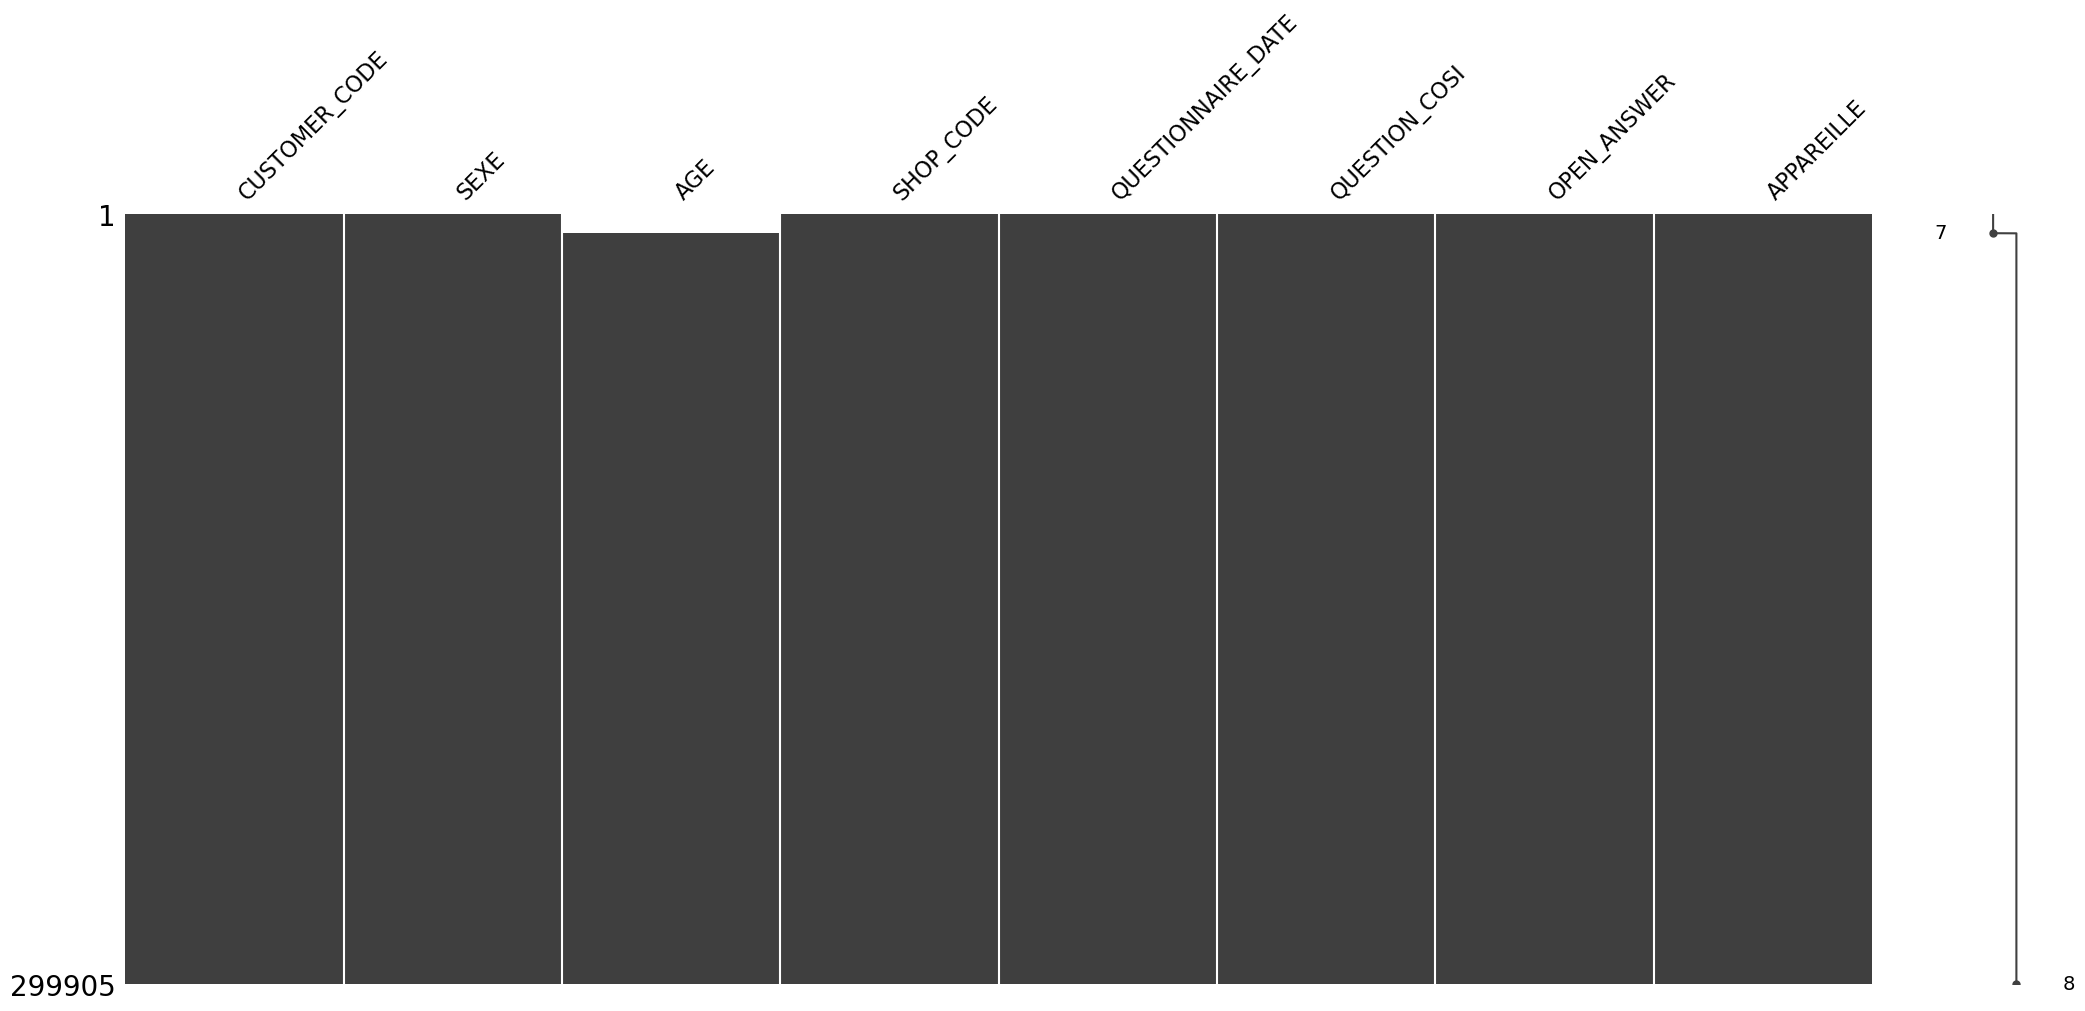

In [12]:
msno.matrix(df_test_Q1)

In [13]:
missing_percent_q1 = df_test_Q1.isna().mean() * 100  # Returns a Series with percentages of missing values
missing_percent_q1

CUSTOMER_CODE         0.000000
SEXE                  0.000000
AGE                   2.509128
SHOP_CODE             0.000000
QUESTIONNAIRE_DATE    0.000000
QUESTION_COSI         0.000000
OPEN_ANSWER           0.000000
APPAREILLE            0.000000
dtype: float64

In [14]:
comments = df_test_Q1['OPEN_ANSWER']

In [15]:
len(comments)

299905

In [ ]:
#############################################
#############################################
#re run the model by removing the duplicates#
#############################################
#############################################

In [16]:
# Encode the comments
tokenized_comments_ids = [tokenizer.encode(comment,add_special_tokens=True,max_length=MAX_LEN) for comment in comments]
# Pad the resulted encoded comments
tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks 
attention_masks = []
for seq in tokenized_comments_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(tokenized_comments_ids)
prediction_masks = torch.tensor(attention_masks)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
#######################################################################################################
# THIS DOES NOT WORK FOR SPACE REASON 6 WE THEN APPLY THE FOLLOWING PART ON BATCHES IN THE CODE BELOW #
#######################################################################################################

# Apply the finetuned model (Camembert)
#flat_pred = []
#with torch.no_grad():
#    # Forward pass, calculate logit predictions
#    outputs =  model(prediction_inputs.to(device),token_type_ids=None, attention_mask=prediction_masks.to(device))
#    logits = outputs[0]
#    logits = logits.detach().cpu().numpy() 
#    flat_pred.extend(np.argmax(logits, axis=1).flatten())

In [34]:
#for i in range(len(flat_pred)):
#    print('Comment: ', comments.iloc[i]) #print('Comment: ', comments[i]) only for today
#    print('Label', flat_pred[i])

Comment:  mieux entendre au quotidien sa femme
Label 4
Comment:  mieux comprendre dans la vie quotidienne
Label 4
Comment:  AMELIORATION COMPREHENSION MILIEU CALME
Label 4
Comment:  entendre mieux madame  lorsqu'elle est tournée et qu'elle puisse parler moins fort
Label 0
Comment:  entendre mieux la tv
Label 6
Comment:  est venue faire un depistage 
Label 1
Comment:  madame est venue pour faire un depistage
Label 1
Comment:  est venu pour un dépistage
Label 1
Comment:  est venu faire un dépistage
Label 1
Comment:  est venu pour faire un dépistage
Label 1
Comment:  entendre mieux son fils
Label 4
Comment:  Mettre le son de la tv moins fort
Label 6
Comment:  Moins percevoir l'acouphène
Label 0
Comment:  Faire le point sur l'audrition
Label 1
Comment:  mieux entendre la télévision
Label 6
Comment:  vient faire un dépistage auditif
Label 1
Comment:  CHERCHE LE MEILLEUR CENTRE
Label 0
Comment:  elle n'est pas génée
Label 0
Comment:  est venu pour un dépistage
Label 1
Comment:  venu pour un 

In [40]:
# Create a list of labels based on flat_pred
#labels = [list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in flat_pred]

# Create a DataFrame
#result_df = pd.DataFrame({'Comments': comments, 'Flat_Pred': flat_pred, 'Labels': labels})


In [41]:
# Specify the file path where you want to save the Excel file
#excel_file_path = 'C:/Users/mcampi/Desktop/Postdoc_Pasteur/Perrine/data/Cosi_Labelled/result_prova_df.xlsx'

# Export the DataFrame to Excel
#result_df.to_excel(excel_file_path, index=False)

In [17]:
batch_size = 8  # You can adjust this based on your available memory

# Create DataLoader for batching
data = torch.utils.data.TensorDataset(torch.tensor(tokenized_comments_ids), torch.tensor(attention_masks))
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size)

flat_pred = []

# Apply the finetuned model (Camembert) on batches
with torch.no_grad():
    model.eval()
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch

        # Forward pass, calculate logit predictions for each batch
        batch_outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        batch_logits = batch_outputs[0]
        batch_logits = batch_logits.detach().cpu().numpy()

        flat_pred.extend(np.argmax(batch_logits, axis=1).flatten())

In [18]:
len(flat_pred)

299905

In [ ]:
for i in range(len(flat_pred)):
    print('Comment: ', comments[i])
    print('Label', flat_pred[i])

In [19]:
# Create a list of labels based on flat_pred
labels = [list(label_mapping.keys())[list(label_mapping.values()).index(pred)] for pred in flat_pred]

# Create a DataFrame
result_df = pd.DataFrame({'Comments': comments, 'Flat_Pred': flat_pred, 'Labels': labels})


In [22]:
# Specify the file path where you want to save the Excel file
excel_file_path = 'C:/Users/mcampi/Desktop/Postdoc_Pasteur/Perrine/data/Cosi_Labelled/result_Q1.xlsx'

# Export the DataFrame to Excel
result_df.to_excel(excel_file_path, index=False)